In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os
import seaborn as sns 
from pyabc import (Distribution, History)

In [2]:
# Experiments
outgrowth_df = pd.read_csv('./outgrowth.csv')
outgrowth_df.set_index(['day', 'tail'], inplace=True)
outgrowth_mean = outgrowth_df.groupby('day').mean()['outgrowth']

percentage_df = pd.read_csv('./percentage_100um.csv')
df = percentage_df
for day in range(0,6):
    df.loc[df['day'] == day, 'position'] = (outgrowth_mean[day] - (df.loc[df['day'] == day, 'position']-100)).astype(int)
percentage_df = df
percentage_df.set_index(['day', 'tail', 'position'], inplace=True)
percentage_df = percentage_df.drop(['unlabelled'], axis=1)
experiments = percentage_df

In [3]:
means,stds = {},{}
for day,df_day in percentage_df.groupby(level='day'):
        tails_mean, tails_std = {},{}
        for tail,df_animal in df_day.groupby(level='tail'):
            db_path = ("sqlite:///" + os.path.join("./fitting_results/",
                                               "sp_fitting-day="+str(day)+"-tail="+str(tail)+".db"))
            h = History(db_path)       
            df = h.get_distribution()
            tails_mean[tail] = df[0].mean()
            tails_std[tail] = df[0].std() 
            
        means[day] = pd.DataFrame.from_dict(tails_mean, orient='index')
        stds[day] = pd.DataFrame.from_dict(tails_std, orient='index')
means = pd.concat(means, names=['day','tail'])   
means['sp'] = outgrowth_mean-means['sp']
stds = pd.concat(stds, names=['day','tail'])   
day_means = means.groupby('day').mean()
day_std = means.groupby('day').std()

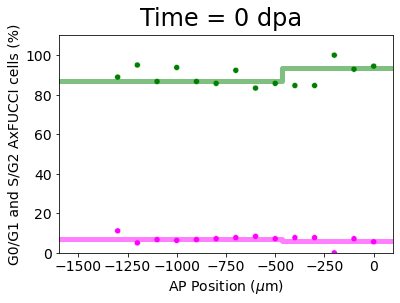

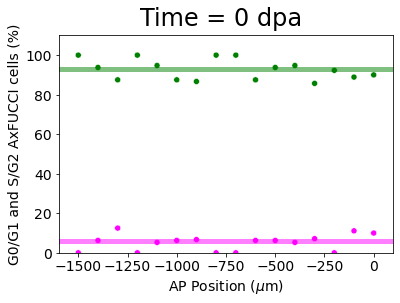

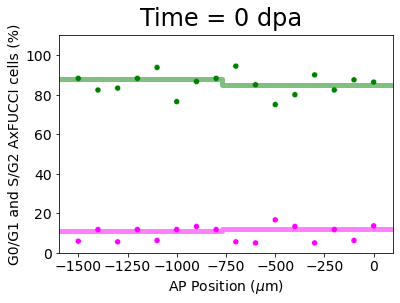

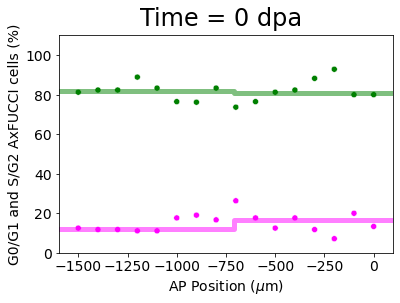

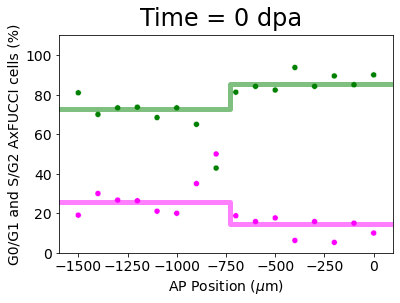

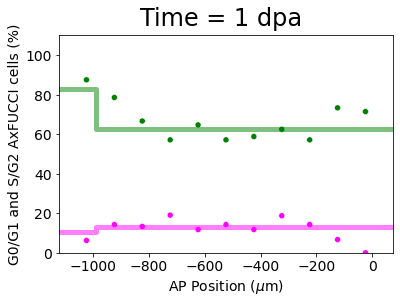

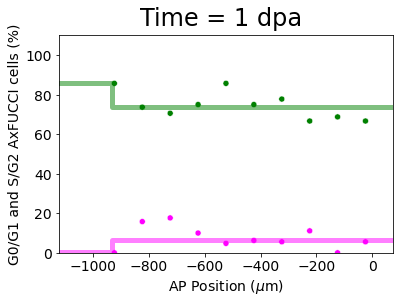

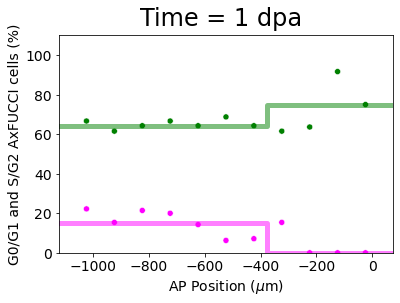

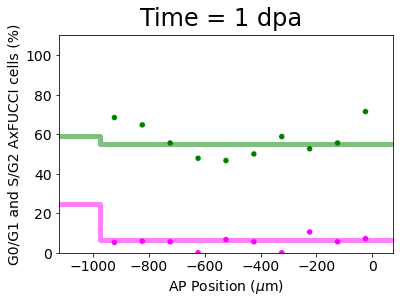

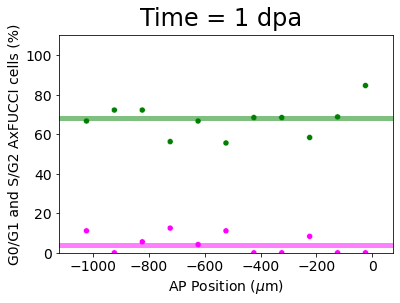

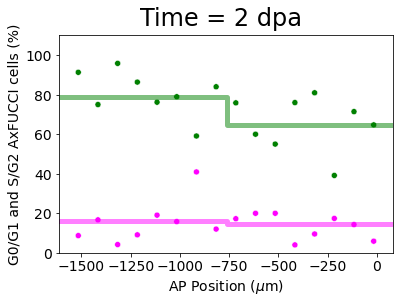

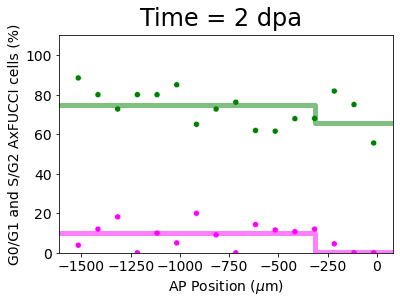

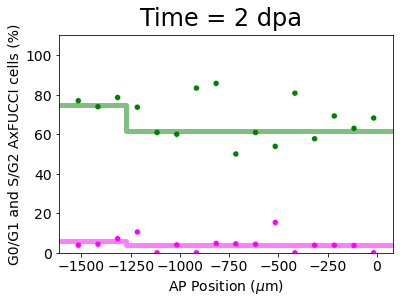

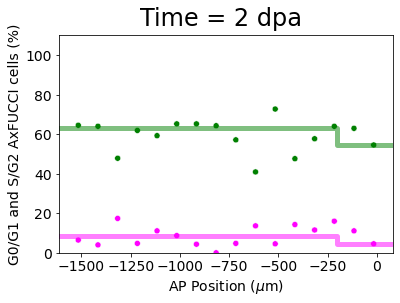

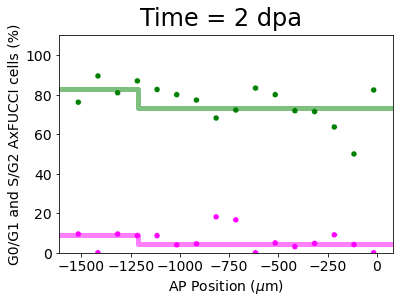

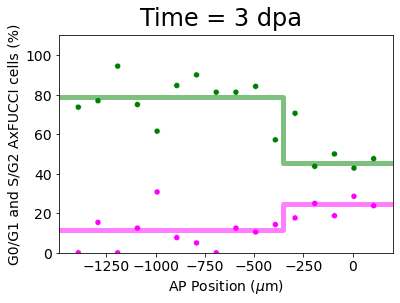

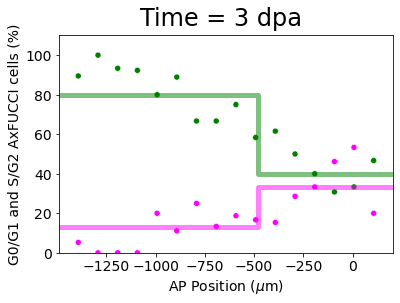

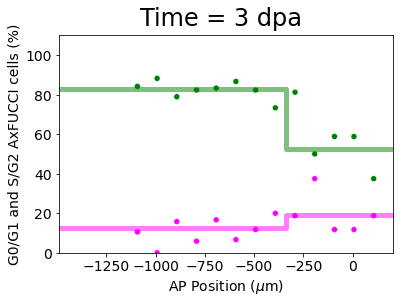

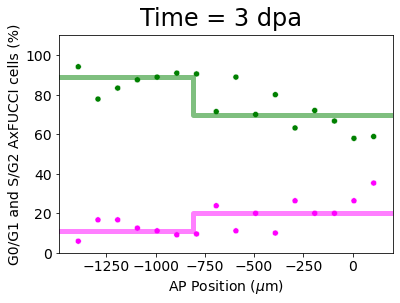

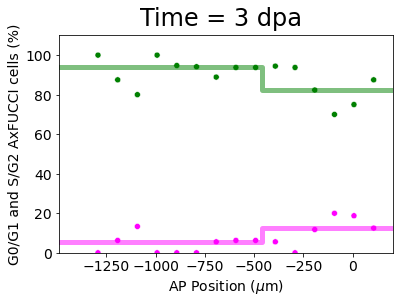

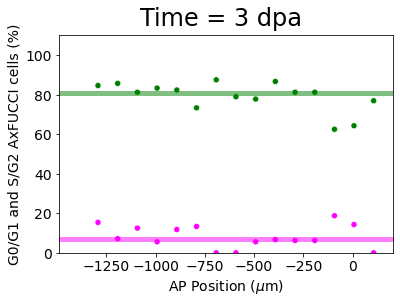

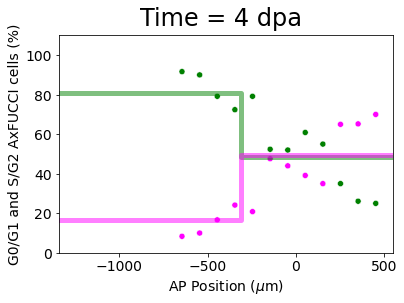

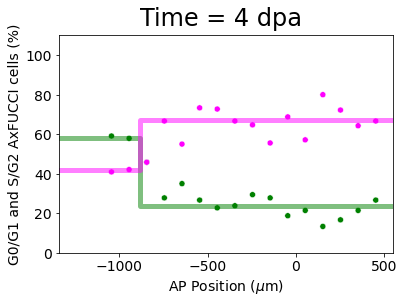

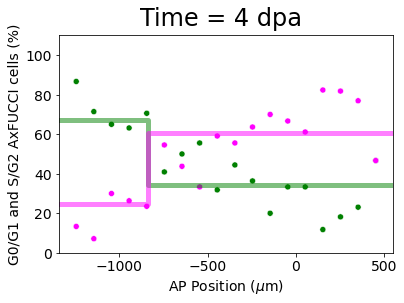

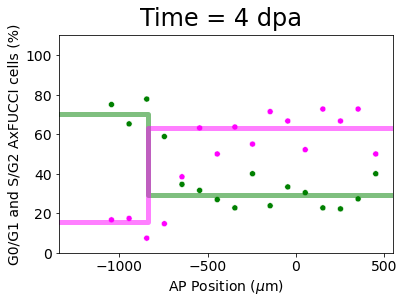

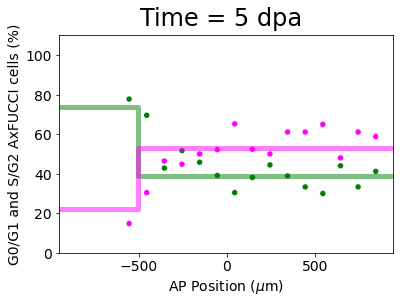

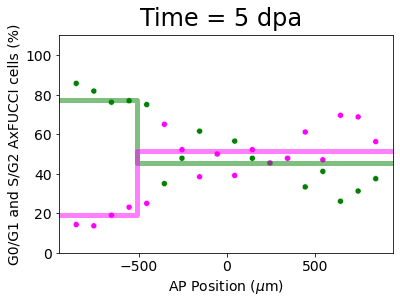

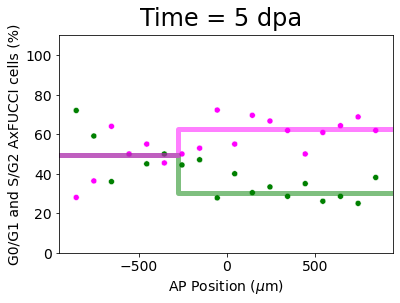

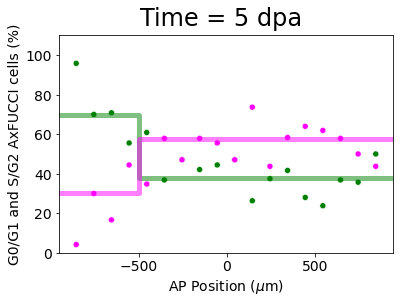

In [6]:
# Local fitting plots
for day in range(0,6):
# Iterates over each day

    meansDay  = means.xs(day,level='day')
    pos = experiments.sort_index().xs(day,level='day').groupby('position').mean().dropna().index
    data = experiments.sort_index().xs(day,level='day').reset_index().dropna()
        
    for tail in data['tail'].unique():
    # Iterates over each animal tail
        meansDayTail = meansDay.iloc[tail-1]
        sp_mean = meansDayTail['sp']
        c1g = meansDayTail['c1g']
        c2g = meansDayTail['c2g']
        c1m = meansDayTail['c1m']
        c2m = meansDayTail['c2m']
        
        dataTail = data[data['tail']==tail]

        # Two zones signals values plotted before and after the AP-border (green signal)
        ax = sns.scatterplot(x='position', y='green', data=dataTail,style='tail',color='green')
        ax.step([-3000,sp_mean,sp_mean,3000], [c2g,c2g,c1g,c1g], color='green',linewidth=5,alpha=0.5)

        # Two zones signals values plotted before and after the AP-border (magenta signal)
        ax = sns.scatterplot(x='position', y='magenta', data=dataTail,color='magenta',style='tail')
        ax.step([-3000,sp_mean,sp_mean,3000], [c2m,c2m,c1m,c1m], color='magenta',linewidth=5,alpha=0.5)

        title = 'Time = '+ str(day)+" dpa"
        plt.xlim(data['position'].min()-100,data['position'].max()+100)
        plt.ylim(0,110)
        plt.xlabel('AP Position' + ' (' + r'$\mu$'+'m)')
        plt.ylabel('G0/G1 and S/G2 AxFUCCI cells (%)')
        plt.suptitle(title,size='24')    
        plt.rcParams.update({'font.size': 14})
        plt.legend([],[], frameon=False)
        plt.savefig('./day_'+str(day)+'-'+'tail_'+str(tail), dpi=300, bbox_inches='tight')
        plt.show()